In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), "..")))
from example_package import model, training, datasets, metrics
from tqdm import tqdm
from scipy.stats import bootstrap
import pickle
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
def get_postfix(exp_name,cvar_name,cvar_value):
    return f'{exp_name}/{cvar_name}_{cvar_value}'

In [105]:
n_visible = 4
#n_hidden = 2
dataset = datasets.BasicEncoderDataset(n_visible).data[:]

In [106]:
#model paramss
epochs = 100
bias = True
learning_rate = 2
noise_levels = [0.05,0.15] # [p_flip_to_zero,p_flip_to_one]
annealing_scheme = torch.Tensor([20,20,15,15,12,12,10,10,10,10])
steps_statistics = 10
train_params = {
    'double_clamped':False, #bad, do not use
    'discretize_gradients':True
}

In [110]:
exp_name = 'test'
cvar_name = 'n_hidden'

In [115]:
#control variable 
control_all = [2,3]
#statistics
n_repetitions = 2
data = np.zeros((len(control_all),n_repetitions))
for i,control in tqdm(enumerate(control_all)):
    file_name = f'../data/{get_postfix(exp_name,cvar_name,control)}.pkl'
    for j in tqdm(range(n_repetitions)):
        n_hidden = control
        # Make an object from the model and train it
        model_B = model.BoltzmannMachine(2*n_visible, n_hidden, None, bias)
        training.TrainBatch(model_B,dataset, epochs, learning_rate,noise_levels,steps_statistics,annealing_scheme,
                            train_params,tqdm=False)
        vector_s1, vectors_2 = metrics.get_encoding_vectors(model_B)
        hamming_data = metrics.hamming_distance(np.sign(vector_s1).T)
        data_point = hamming_data[2]
        data[i,j] = data_point
    pickle.dump(data[i], open(file_name,'wb+'))
file_name = f'../data/{exp_name}/{cvar_name}_xvals.pkl'
pickle.dump(control_all, open(file_name,'wb+'))

100%|██████████| 2/2 [00:15<00:00,  7.83s/it]
2it [00:29, 14.55s/it]


In [86]:
# # data_o = data
# # x_o = epochs_all
# data_spliced = np.concatenate((data_o,data))
# x_spliced = np.concatenate((x_o,epochs_all))

In [87]:
def mean_statistic(data, axis=1):
    return np.mean(data, axis=axis)

In [88]:
print(data.shape)
means_bs = bootstrap((data,), mean_statistic,axis=1)#, n_resamples=1000, vectorized=True, axis=0)
ci_lower,ci_upper = means_bs.confidence_interval

(4, 2)


c:\Coding\miniconda\envs\boltz\Lib\site-packages\scipy\stats\_resampling.py:147: RuntimeWarning: invalid value encountered in divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
c:\Coding\miniconda\envs\boltz\Lib\site-packages\scipy\_lib\_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


In [93]:
y_lims = (0,np.max(data))

C:\Users\Mark\AppData\Local\Temp\ipykernel_27080\1642904603.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


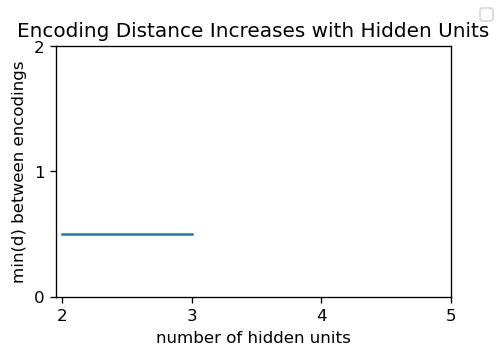

In [116]:
fig, ax = plt.subplots(figsize=(4,3),dpi=120)
ax.plot(control_all,np.mean(data,1))
#ax.fill_between(hidden_all, ci_lower, ci_upper, color='blue', alpha=0.2, label='Confidence Interval')
ax.set_xlabel('number of hidden units')
ax.set_ylabel('min(d) between encodings')
ax.set_yticks(np.linspace(*y_lims,3))
ax.set_xticks([2,3,4,5])
fig.legend()
#ax.set_xscale('log')
ax.set_title('Encoding Distance Increases with Hidden Units')
fig.tight_layout()
fig.savefig('encoding_distance.png')
plt.show()